### Read transformed data

In [2]:
import pandas as pd

df = pd.read_csv("atp_transformed/2000-2024 with covid.csv")

df.head()

C:\Users\Rusty\AppData\Local\Temp\ipykernel_25008\54908254.py:3: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("atp_transformed/2000-2024 with covid.csv")


,tourney_id,tourney_name,tourney_type,surface,draw_size,tourney_level,tourney_date,match_num,score,round_1,...,double_faults,points_on_serve,first_serve_in,1st_won,2nd_won,service_games,break_points_saved,break_points_faced,match_outcome,player_tourney_match_id
0,2000-301,Auckland,matches,Hard,32,A,2000-01-10,1,7-5 4-6 7-5,7-5,...,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,1,103163:2000-301:1
1,2000-301,Auckland,matches,Hard,32,A,2000-01-10,1,7-5 4-6 7-5,7-5,...,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,0,101543:2000-301:1
2,2000-301,Auckland,matches,Hard,32,A,2000-01-10,2,7-5 7-5,7-5,...,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,1,102607:2000-301:2
3,2000-301,Auckland,matches,Hard,32,A,2000-01-10,2,7-5 7-5,7-5,...,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,0,102644:2000-301:2
4,2000-301,Auckland,matches,Hard,32,A,2000-01-10,3,6-3 6-1,6-3,...,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,1,103252:2000-301:3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289980 entries, 0 to 1289979
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tourney_id               1289980 non-null  object 
 1   tourney_name             1289980 non-null  object 
 2   tourney_type             1289980 non-null  object 
 3   surface                  1289874 non-null  object 
 4   draw_size                1289980 non-null  int64  
 5   tourney_level            1289980 non-null  object 
 6   tourney_date             1289980 non-null  object 
 7   match_num                1289980 non-null  int64  
 8   score                    1289880 non-null  object 
 9   round_1                  1289810 non-null  object 
 10  round_2                  1284520 non-null  object 
 11  round_3                  433102 non-null   object 
 12  round_4                  25000 non-null    object 
 13  round_5                  6832 non-null    

In [4]:
df.columns

Index(['tourney_id', 'tourney_name', 'tourney_type', 'surface', 'draw_size',
       'tourney_level', 'tourney_date', 'match_num', 'score', 'round_1',
       'round_2', 'round_3', 'round_4', 'round_5', 'best_of', 'tourney_round',
       'minutes', 'player_id', 'player_seed', 'player_name', 'player_hand',
       'player_height', 'player_country', 'player_age', 'player_rank',
       'player_rank_points', 'ace', 'double_faults', 'points_on_serve',
       'first_serve_in', '1st_won', '2nd_won', 'service_games',
       'break_points_saved', 'break_points_faced', 'match_outcome',
       'player_tourney_match_id'],
      dtype='object')

#### Add Average Win Rate

In [5]:
df_copy = df.copy()

player_agg = (
    df.groupby('player_id')
      .agg(
          player_name=('player_name', 'first'),
          total_wins=('match_outcome', 'sum'),
          matches_played=('match_outcome', 'count')
      )
      .reset_index()
)

# Calculate average win rate
player_agg['average_win_rate'] = round(player_agg['total_wins'] / player_agg['matches_played'], 2)

# Merge average_win_rate back into the full dataframe copy
df_copy = df_copy.merge(player_agg[['player_id', 'average_win_rate']], on='player_id', how='left')

# Aggregated table for summaries
player_stats = player_agg[['player_id', 'player_name', 'total_wins', 'matches_played', 'average_win_rate']]

#### Wins against a top 10 opponent

In [6]:
# 1. Get winners and losers with their tourney_match_id and rank
winners = df_copy[df_copy['match_outcome'] == 1][['player_tourney_match_id', 'player_id']].copy()
losers = df_copy[df_copy['match_outcome'] == 0][['player_tourney_match_id', 'player_rank']].copy()


# 2. Extract just the tourney match ID (everything after the first ':')
winners['tourney_match_id'] = winners['player_tourney_match_id'].str.split(':').str[1:]
winners['tourney_match_id'] = winners['tourney_match_id'].str.join(':')

losers['tourney_match_id'] = losers['player_tourney_match_id'].str.split(':').str[1:]
losers['tourney_match_id'] = losers['tourney_match_id'].str.join(':')

# 3. Rename the loser's rank column to avoid confusion
losers = losers.rename(columns={'player_rank': 'opponent_rank'})

# 4. Merge on the clean tourney_match_id
winner_vs_loser = pd.merge(
    winners[['player_id', 'tourney_match_id']], 
    losers[['tourney_match_id', 'opponent_rank']], 
    on='tourney_match_id', 
    how='inner'
)

# 5. Create wins_against_top_10 column and aggregate
winner_vs_loser['win_against_top_10'] = (winner_vs_loser['opponent_rank'] <= 10).astype(int)
top_10_wins = winner_vs_loser.groupby('player_id')['win_against_top_10'].sum().reset_index()

# 6. Merge back into df_copy
df_copy = df_copy.merge(top_10_wins, on='player_id', how='left')
df_copy['win_against_top_10'] = df_copy['win_against_top_10'].fillna(0).astype(int)


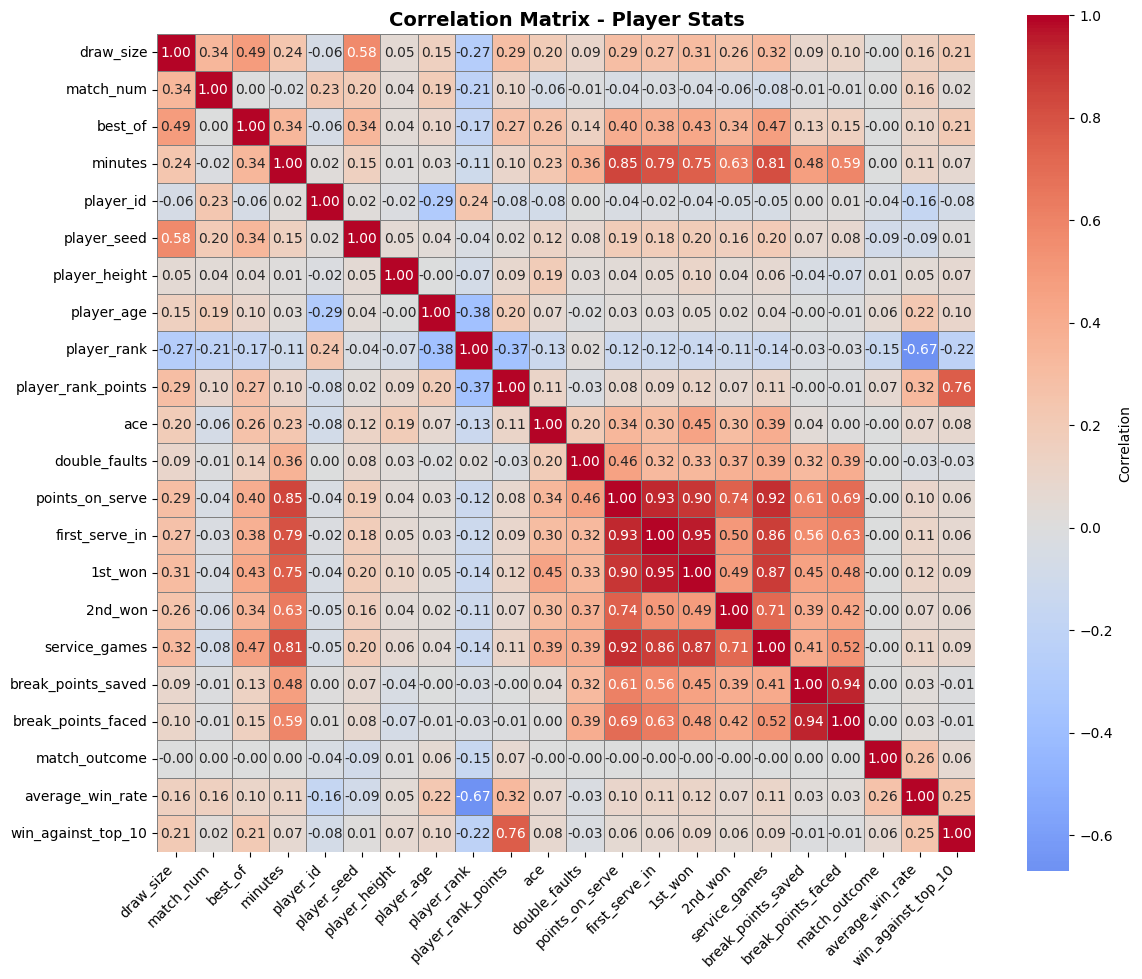

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix of numeric columns in player_stats
corr_matrix = df_copy.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            fmt='.2f', cbar_kws={'label': 'Correlation'}, linewidths=0.5, linecolor='gray')
plt.title('Correlation Matrix - Player Stats', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()